| **Name**         | Tufan Kundu               |
|------------------|---------------------------|
| **Reg No.**      | 24MDT0184                 |
| **Course Name**  | Financial Analytics    |
| **Course Code**  | PMDS610L                  |
| **Assessment**   | Digital Assignment 2  |

# Problem Statement
Predict the NIFTY 50 index values for the next 10 days using historical data from the past 3 years. The prediction should be performed by implementing and comparing the following time series models:

ARIMA (Autoregressive Integrated Moving Average), Regression with Time Series Error, ARFIMA (Autoregressive Fractionally Integrated Moving Average), GARCH (Generalized Autoregressive Conditional Heteroskedasticity)

### Import necessary Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from arch import arch_model
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

### Load and prepare data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


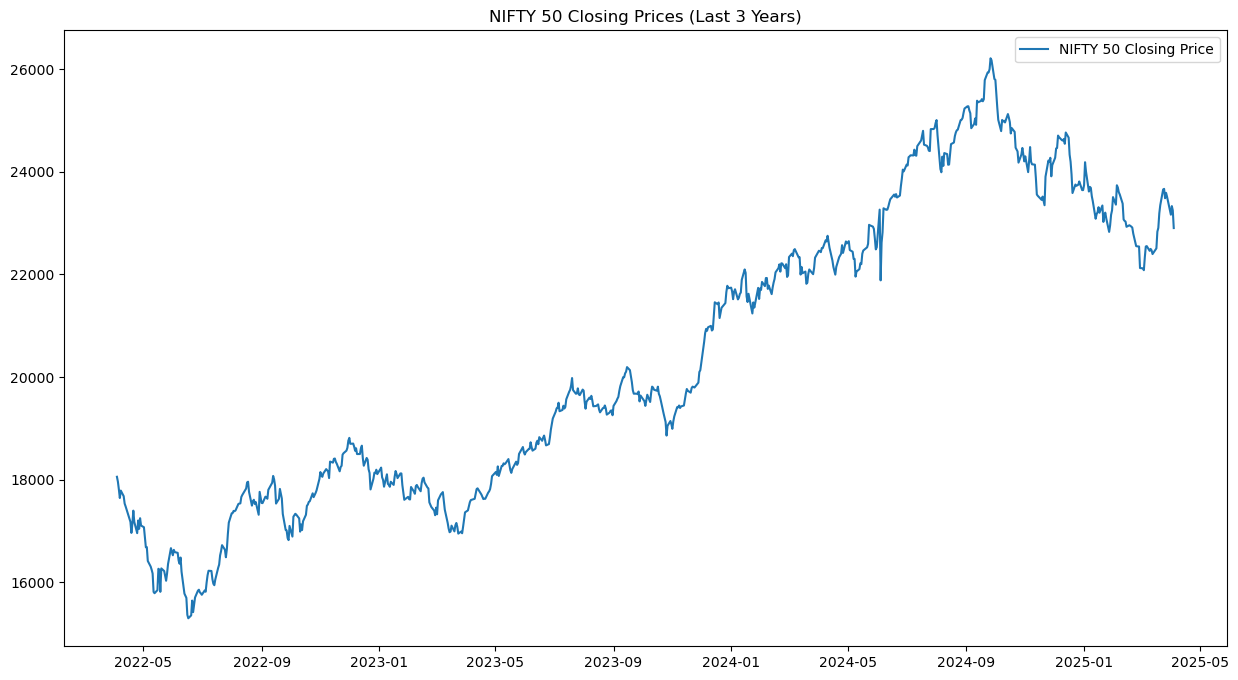

In [2]:
nifty_data = yf.download('^NSEI', period="3y", interval="1d")
df = nifty_data[['Close']].dropna()

# Create returns for volatility modeling
df['Returns'] = df['Close'].pct_change().dropna()

# Plot the data
plt.figure(figsize=(15, 8))
plt.plot(df['Close'], label='NIFTY 50 Closing Price')
plt.title('NIFTY 50 Closing Prices (Last 3 Years)')
plt.legend()

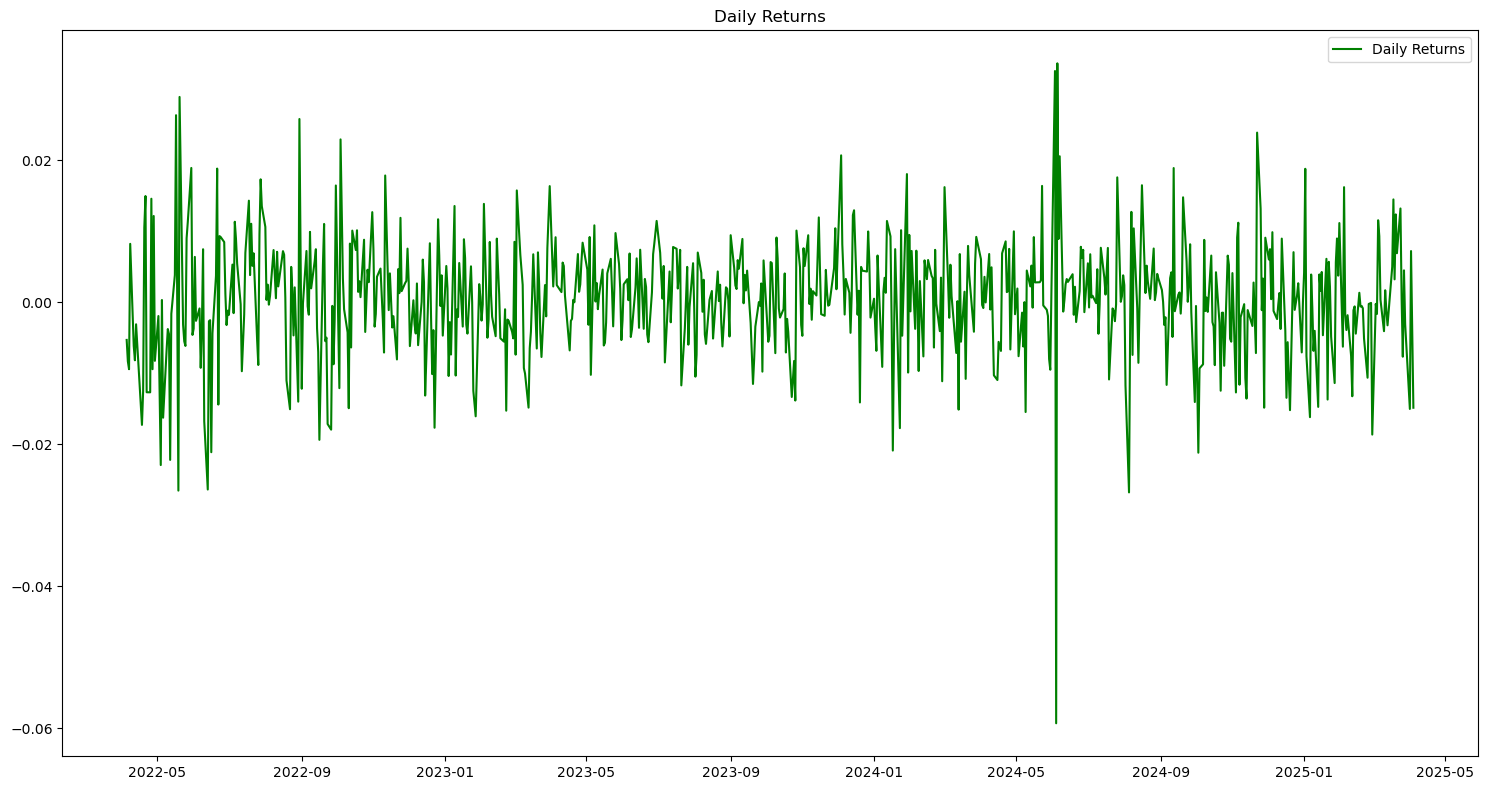

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(df['Returns'], label='Daily Returns', color='green')
plt.title('Daily Returns')
plt.legend()
plt.tight_layout()
plt.show()

### Check stationarity using Adfuller

In [4]:
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

print("Stationarity test for Close prices:")
test_stationarity(df['Close'])

Stationarity test for Close prices:
ADF Statistic: -0.7602317513297161
p-value: 0.8305255752841794
Critical Values: {'1%': -3.4392057325732104, '5%': -2.8654483492874236, '10%': -2.5688512291811225}



Stationarity test for differenced series:
ADF Statistic: -28.17810031286188
p-value: 0.0
Critical Values: {'1%': -3.4392177416762086, '5%': -2.8654536415414684, '10%': -2.5688540485756026}


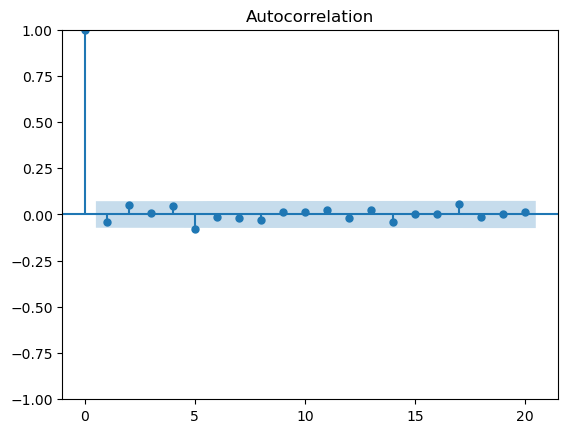

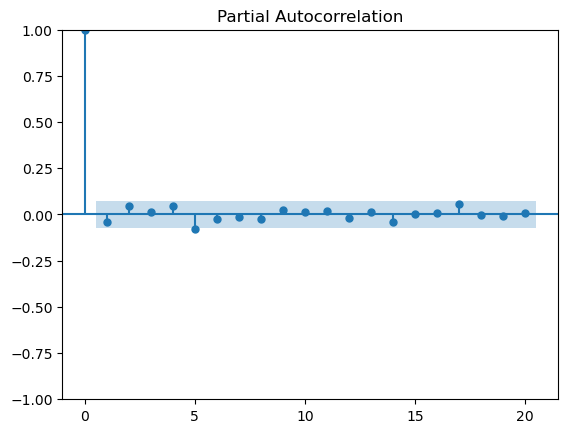

In [5]:
# Difference to make stationary
df['Close_diff'] = df['Close'].diff().dropna()
print("\nStationarity test for differenced series:")
test_stationarity(df['Close_diff'])

# Determine ARIMA parameters
plot_acf(df['Close_diff'].dropna(), lags=20)
plot_pacf(df['Close_diff'].dropna(), lags=20)
plt.show()

## **Arima**

### Auto ARIMA to find best parameters

In [6]:
auto_model = auto_arima(df['Close'], seasonal=False, trace=True,error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9711.973, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9707.644, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9708.379, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9708.503, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9706.758, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9708.250, Time=1.23 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.151 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  742
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4852.379
Date:                Sat, 05 Apr 2025   AIC                           9706.758
Time:                        22:03:09   BIC                           9711.366
Sample:                             0   HQIC                          9708.535
          

### Splitting the Data

In [7]:
# Split train-test (last 30 days for testing)
train = df['Close'][:-30]
test = df['Close'][-30:]

# Fit ARIMA model (using parameters from auto_arima)
model_arima = ARIMA(train, order=(2,1,2))
model_arima_fit = model_arima.fit()
print(model_arima_fit.summary())

# Forecast
forecast = model_arima_fit.forecast(steps=30)
rmse = sqrt(mean_squared_error(test, forecast))
print(f'ARIMA RMSE: {rmse}')

                               SARIMAX Results                                
Dep. Variable:                  ^NSEI   No. Observations:                  712
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4650.678
Date:                Sat, 05 Apr 2025   AIC                           9311.355
Time:                        22:03:10   BIC                           9334.188
Sample:                             0   HQIC                          9320.175
                                - 712                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7426      4.027     -0.184      0.854      -8.635       7.149
ar.L2         -0.0204      3.079     -0.007      0.995      -6.055       6.014
ma.L1          0.6964      4.018      0.173      0.8

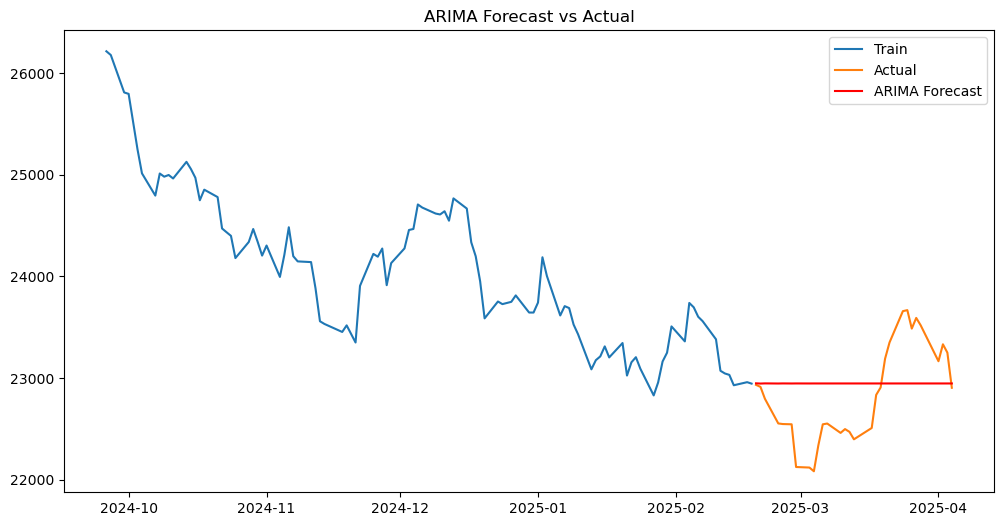

In [8]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-100:], train[-100:], label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

## **Regression with Time Series**

### Determine optimal lags using PACF

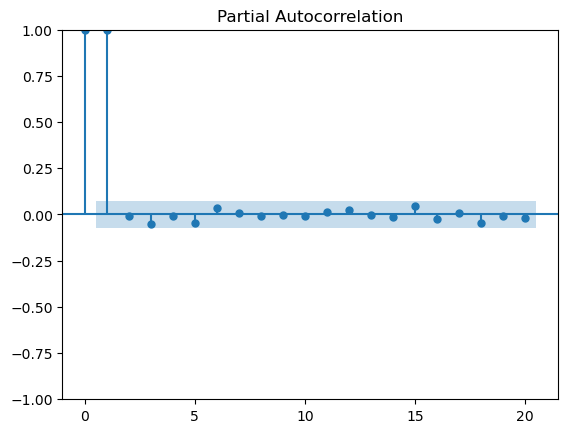

                            AutoReg Model Results                             
Dep. Variable:                  ^NSEI   No. Observations:                  712
Model:                     AutoReg(5)   Log Likelihood               -4623.779
Method:               Conditional MLE   S.D. of innovations            167.513
Date:                Sat, 05 Apr 2025   AIC                           9261.558
Time:                        22:03:10   BIC                           9293.485
Sample:                             5   HQIC                          9273.894
                                  712                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7769     44.747      0.934      0.350     -45.925     129.479
^NSEI.L1       0.9494      0.038     25.284      0.000       0.876       1.023
^NSEI.L2       0.0945      0.052      1.827      0.0

In [9]:
plot_pacf(df['Close'], lags=20)
plt.show()

# Fit AutoReg model (using 5 lags based on PACF)
model_autoreg = AutoReg(train, lags=5)
model_autoreg_fit = model_autoreg.fit()
print(model_autoreg_fit.summary())

# Forecast
forecast_autoreg = model_autoreg_fit.predict(start=len(train), end=len(train)+29)
rmse_autoreg = sqrt(mean_squared_error(test, forecast_autoreg))
print(f'AutoReg RMSE: {rmse_autoreg}')


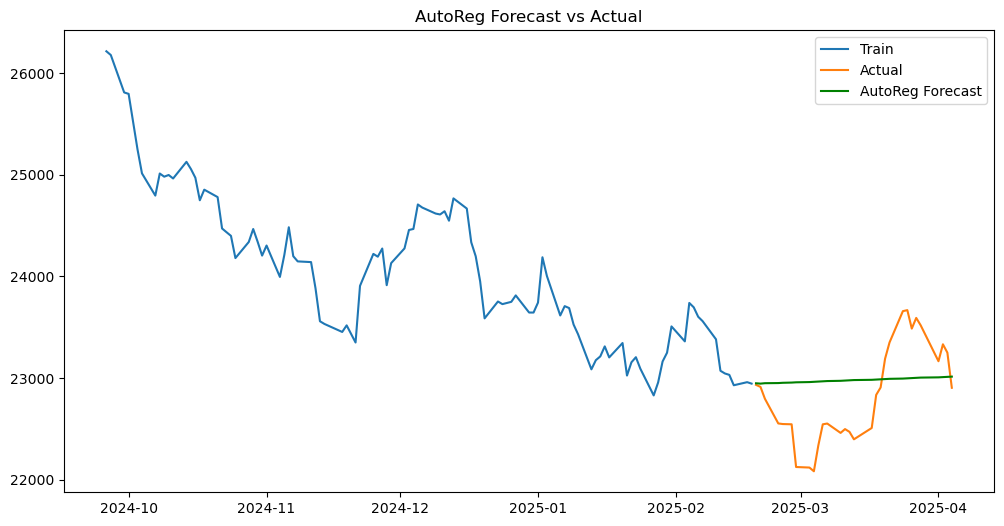

In [10]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(train.index[-100:], train[-100:], label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_autoreg, label='AutoReg Forecast', color='green')
plt.title('AutoReg Forecast vs Actual')
plt.legend()
plt.show()

## **Automated ARFIMA modeling**

In [11]:
close_series = nifty_data['Close'].dropna()
print("Searching for best ARFIMA parameters...")
model = auto_arima(close_series,
                   start_p=0, max_p=3,    # AR order
                   start_q=0, max_q=3,    # MA order
                   d=None,               # Let model determine differencing
                   test='adf',           # Augmented Dickey-Fuller test
                   seasonal=False,       # No seasonality
                   trace=True,           # Print progress
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)        # Smart parameter search

print("\nBest model summary:")
print(model.summary())


Searching for best ARFIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9707.644, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9708.379, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9708.503, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9706.758, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9708.250, Time=1.46 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.954 seconds

Best model summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  742
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4852.379
Date:                Sat, 05 Apr 2025   AIC                           9706.758
Time:                        22:03:13   BIC                           9711.366
Sample:                             0   HQIC                          9708.535
               

In [12]:
# Forecast next 30 days
forecast, conf_int = model.predict(n_periods=30, return_conf_int=True)
forecast_index = pd.date_range(start=close_series.index[-1] + pd.Timedelta(days=1), periods=30)

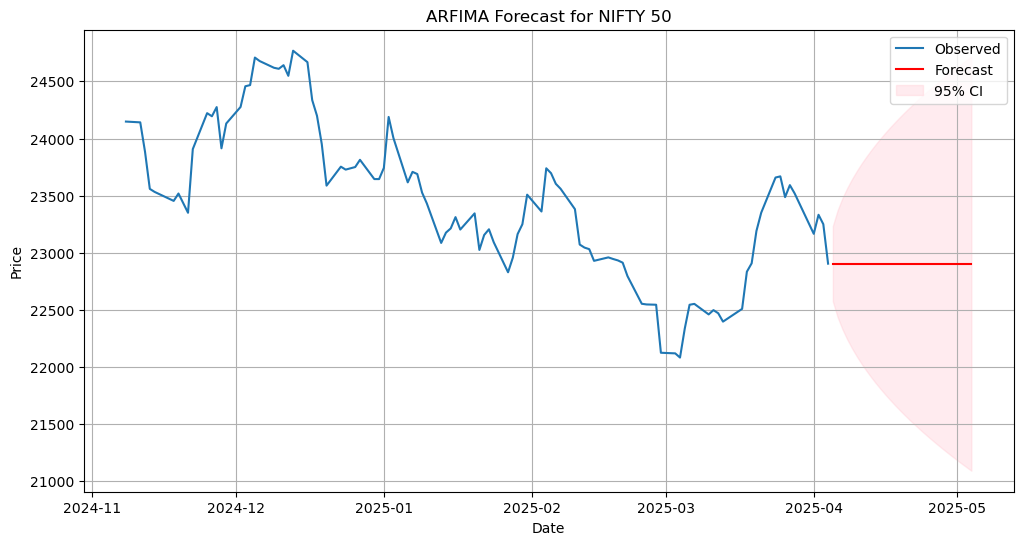

In [13]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(close_series.index[-100:], close_series.values[-100:], label='Observed')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.fill_between(forecast_index,
                conf_int[:,0],
                conf_int[:,1],
                color='pink', alpha=0.3, label='95% CI')
plt.title('ARFIMA Forecast for NIFTY 50')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Print forecasted values
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast,
    'Lower CI': conf_int[:,0],
    'Upper CI': conf_int[:,1]
})
print("\n30-day Forecast:")
print(forecast_df.round(2))


30-day Forecast:
          Date  Forecast  Lower CI  Upper CI
742 2025-04-05  22904.45  22573.58  23235.32
743 2025-04-06  22904.45  22436.53  23372.37
744 2025-04-07  22904.45  22331.36  23477.54
745 2025-04-08  22904.45  22242.70  23566.19
746 2025-04-09  22904.45  22164.60  23644.30
747 2025-04-10  22904.45  22093.98  23714.92
748 2025-04-11  22904.45  22029.04  23779.86
749 2025-04-12  22904.45  21968.60  23840.30
750 2025-04-13  22904.45  21911.83  23897.07
751 2025-04-14  22904.45  21858.14  23950.76
752 2025-04-15  22904.45  21807.07  24001.83
753 2025-04-16  22904.45  21758.27  24050.62
754 2025-04-17  22904.45  21711.47  24097.43
755 2025-04-18  22904.45  21666.44  24142.46
756 2025-04-19  22904.45  21622.99  24185.91
757 2025-04-20  22904.45  21580.96  24227.94
758 2025-04-21  22904.45  21540.23  24268.67
759 2025-04-22  22904.45  21500.68  24308.22
760 2025-04-23  22904.45  21462.21  24346.69
761 2025-04-24  22904.45  21424.74  24384.16
762 2025-04-25  22904.45  21388.20  2

### **GARCH**

In [15]:
returns = df['Returns'].dropna()

### Splitting the Data

In [16]:
# Split train-test
train_ret = returns[:-30]
test_ret = returns[-30:]

# Fit GARCH(1,1) model
model_garch = arch_model(train_ret, mean='Zero', vol='GARCH', p=1, q=1)
model_garch_fit = model_garch.fit(update_freq=5)
print(model_garch_fit.summary())

# Forecast volatility
forecast_garch = model_garch_fit.forecast(horizon=30)
forecast_volatility = np.sqrt(forecast_garch.variance.values[-1,:])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2436.5008155105215
            Iterations: 7
            Function evaluations: 17
            Gradient evaluations: 3
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2436.50
Distribution:                  Normal   AIC:                          -4867.00
Method:            Maximum Likelihood   BIC:                          -4853.30
                                        No. Observations:                  711
Date:                Sat, Apr 05 2025   Df Residuals:                      711
Time:                        22:03:13   Df Model:                            0
                              Volatility Model                              
   

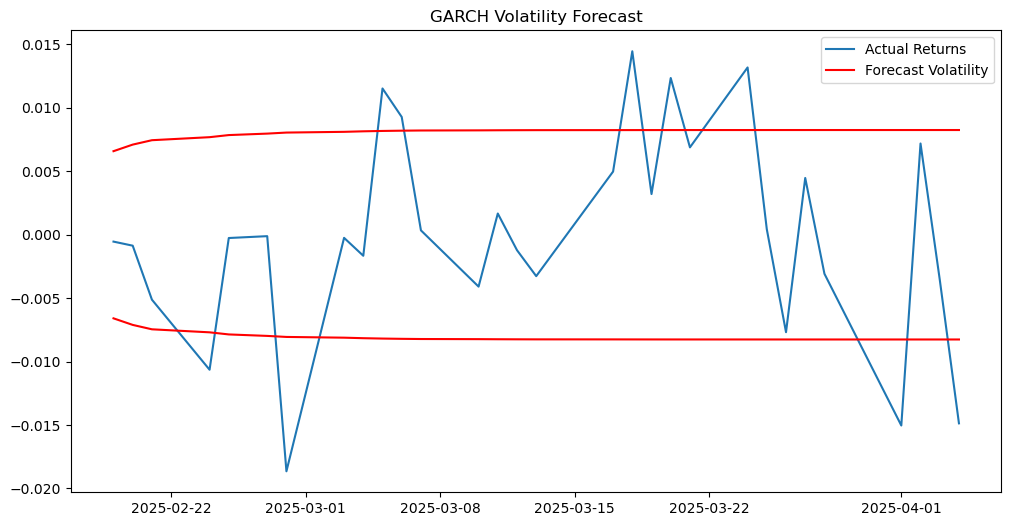

In [17]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(test_ret.index, test_ret, label='Actual Returns')
plt.plot(test_ret.index, forecast_volatility, label='Forecast Volatility', color='red')
plt.plot(test_ret.index, -forecast_volatility, color='red')
plt.title('GARCH Volatility Forecast')
plt.legend()
plt.show()

## **Arima Forecast**

### Generate future dates (10 business days)

In [18]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=10, freq='B')

final_model = ARIMA(df['Close'], order=(2,1,2))
final_model_fit = final_model.fit()
future_forecast = final_model_fit.forecast(steps=10)

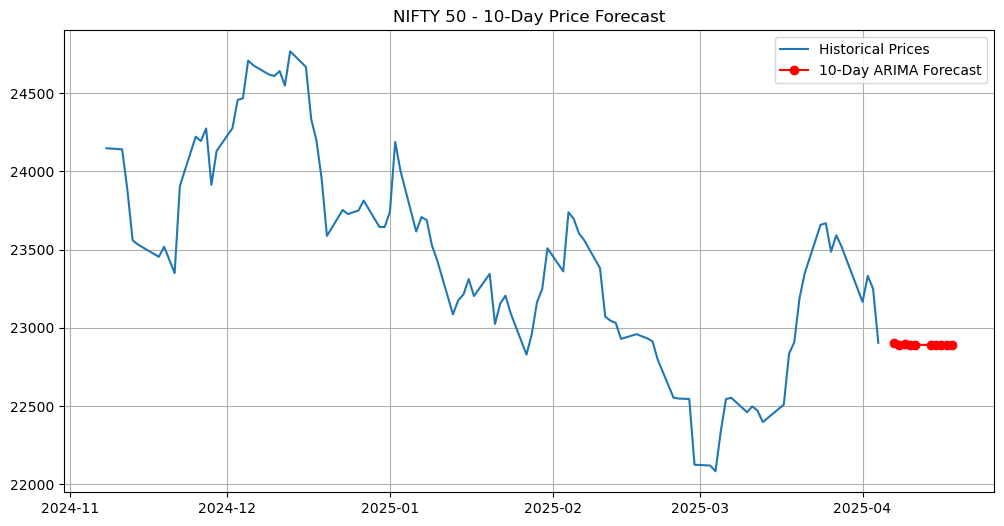

Future Date Forecasts:
          Date      Forecast
742 2025-04-07  22903.249786
743 2025-04-08  22893.288035
744 2025-04-09  22894.733804
745 2025-04-10  22890.672337
746 2025-04-11  22891.997009
747 2025-04-14  22890.200780
748 2025-04-15  22891.047034
749 2025-04-16  22890.202924
750 2025-04-17  22890.685631
751 2025-04-18  22890.272726


In [19]:
# Plot final forecast
plt.figure(figsize=(12,6))
plt.plot(df['Close'][-100:], label='Historical Prices')
plt.plot(future_dates, future_forecast, label='10-Day ARIMA Forecast', color='red', marker='o')
plt.title('NIFTY 50 - 10-Day Price Forecast')
plt.legend()
plt.grid(True)
plt.show()

print("Future Date Forecasts:")
print(pd.DataFrame({'Date': future_dates, 'Forecast': future_forecast}))